# Assignment 1: Data Curation

DATA 512A Fall 2018

Ryan Bae

Due Date: Thursday October 18th, 2018


## Obtaining Data From Wikimedia API

In [33]:
# imports
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
from functools import reduce

In [3]:
# endpoints
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [4]:
# legacy pagecount paramters
params_legacy_desktop = {"project" : 'en.wikipedia.org',
                     "access-site" : "desktop-site",
                     "granularity" : "monthly",
                     "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                     "end" : "2016070100"
                    }
params_legacy_mobile = {"project" : 'en.wikipedia.org',
                     "access-site" : "mobile-site",
                     "granularity" : "monthly",
                     "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                     "end" : "2016070100"
                    }

# pageview parameters
params_pageviews_desktop = {"project" : 'en.wikipedia.org',
                        "access" : "desktop",
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2015070100",
                        # for end use 1st day of month following final month of data
                        "end" : '2018100100'
                        }
params_pageviews_mobileapp = {"project" : 'en.wikipedia.org',
                        "access" : "mobile-app",
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2015070100",
                        # for end use 1st day of month following final month of data
                        "end" : '2018100100'
                        }
params_pageviews_mobileweb = {"project" : 'en.wikipedia.org',
                        "access" : "mobile-web",
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2015070100",
                        # for end use 1st day of month following final month of data
                        "end" : '2018100100'
                        }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/ryanbae89',
    'From': 'rbae@uw.edu'
}

In [5]:
# function for API call
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

In [6]:
# get data from API
# Legacy Pagecounts (desktop-site)
monthly_pagecounts_desktop = api_call(endpoint_legacy, params_legacy_desktop)
# Legacy Pagecounts (mobile)
monthly_pagecounts_mobile = api_call(endpoint_legacy, params_legacy_mobile)
# Pageviews (desktop)
monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
# Pageviews (mobile-app)
monthly_pageviews_mobileapp = api_call(endpoint_pageviews, params_pageviews_mobileapp)
# Pageviews (mobile-web)
monthly_pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)

In [7]:
# save to json files
json_files = ['pagecounts_desktop-site_200712-201607.json',
              'pagecounts_mobile-site_200712-201607.json',
              'pageviews_desktop_201507-201809.json',
              'pageviews_mobile-app_201507-201809.json',
              'pageviews_mobile-web_201507-201809.json']
json_data = [monthly_pagecounts_desktop,
        monthly_pagecounts_mobile,
        monthly_pageviews_desktop,
        monthly_pageviews_mobileapp,
        monthly_pageviews_mobileweb]

for i, filename in enumerate(json_files):
    with open(filename, 'w') as outfile:
        json.dump(json_data[i], outfile)

## Data and Features Engineering

In [8]:
# load json files and combine them into a table
pagecount_desktop = pd.DataFrame.from_dict(monthly_pagecounts_desktop['items'])
pagecount_mobile = pd.DataFrame.from_dict(monthly_pagecounts_mobile['items'])
pageview_desktop = pd.DataFrame.from_dict(monthly_pageviews_desktop['items'])
pageview_mobileapp = pd.DataFrame.from_dict(monthly_pageviews_mobileapp['items'])
pageview_mobileweb = pd.DataFrame.from_dict(monthly_pageviews_mobileweb['items'])

pagecount_desktop.name = 'pagecount_desktop'
pagecount_mobile.name = 'pagecount_mobile'
pageview_desktop.name = 'pageview_desktop'
pageview_mobileapp.name = 'pageview_mobileapp'
pageview_mobileweb.name ='pageview_mobileweb'

pages = [pagecount_desktop, pagecount_mobile, pageview_desktop,
         pageview_mobileapp, pageview_mobileweb]

In [9]:
# functions for data engineering
def clean_data(df, pagetype):
    # get dataframe name for renaming view/count column
    view_str = df.name
    # get year and month for each row
    df['year'] = df['timestamp'].str[:4]
    df['month'] = df['timestamp'].str[4:6]
    # drop unnecessary columns
    df = df.drop(['granularity', 'project', 'timestamp'], axis=1)
    # rename view/count column and drop more unnecessary columns conditionally
    view_str = view_str + '_views'
    if pagetype == 'view':
        df = df.rename(index=str, columns={"views": view_str})
        df = df.drop(['access', 'agent'], axis=1)
    elif pagetype == 'count':
        print(view_str)
        df = df.rename(index=str, columns={"count": view_str})
        df = df.drop('access-site', axis=1)
    return df

# clean data and engineer year/month features
pagecount_desktop = clean_data(pagecount_desktop, 'count')
pagecount_mobile = clean_data(pagecount_mobile, 'count')
pageview_desktop = clean_data(pageview_desktop, 'view')
pageview_mobileapp = clean_data(pageview_mobileapp, 'view')
pageview_mobileweb = clean_data(pageview_mobileweb, 'view')

pagecount_desktop_views
pagecount_mobile_views


In [28]:
# join and sum pageviews_mobileapp and pageviews_mobileweb
pageview_mobile = pageview_mobileapp.merge(right=pageview_mobileweb,
                                             on=['year', 'month'], how='outer')
pageview_mobile['pageview_mobile_views'] = pageview_mobile['pageview_mobileweb_views'] + pageview_mobile['pageview_mobileapp_views']
pageview_mobile = pageview_mobile[['year', 'month', 'pageview_mobile_views']]
pageview_mobile.head()

,year,month,pageview_mobile_views
0,2015,07,3288755294
1,2015,08,3302333038
2,2015,09,3170203333
3,2015,10,3268499132
4,2015,11,3236601070


In [29]:
# join all the tables into a single table for plotting
pages = [pagecount_desktop, pagecount_mobile, pageview_desktop, pageview_mobile]
views = reduce(lambda left, right: pd.merge(left, right, on=['year', 'month'],
               how='outer'), pages)
# fill nans
views = views.fillna(value=0)
# engineer all_views features
views['pagecount_all_views'] = views['pagecount_desktop_views'] + views['pagecount_mobile_views']
views['pageview_all_views'] = views['pageview_desktop_views'] + views['pageview_mobile_views']
# reorder columns
views = views[['year', 'month', 'pagecount_all_views',
              'pagecount_desktop_views', 'pagecount_mobile_views',
              'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]
views.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0


In [30]:
# save views to csv
views.to_csv('en-wikipedia_traffic_200712-201809.csv')

## Visualization

In [31]:
# get time feature for plotting
year_month = pd.DatetimeIndex(start='2007-12-01',end='2018-10-01' , freq='M')
year_month

DatetimeIndex(['2007-12-31', '2008-01-31', '2008-02-29', '2008-03-31',
               '2008-04-30', '2008-05-31', '2008-06-30', '2008-07-31',
               '2008-08-31', '2008-09-30',
               ...
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30'],
              dtype='datetime64[ns]', length=130, freq='M')

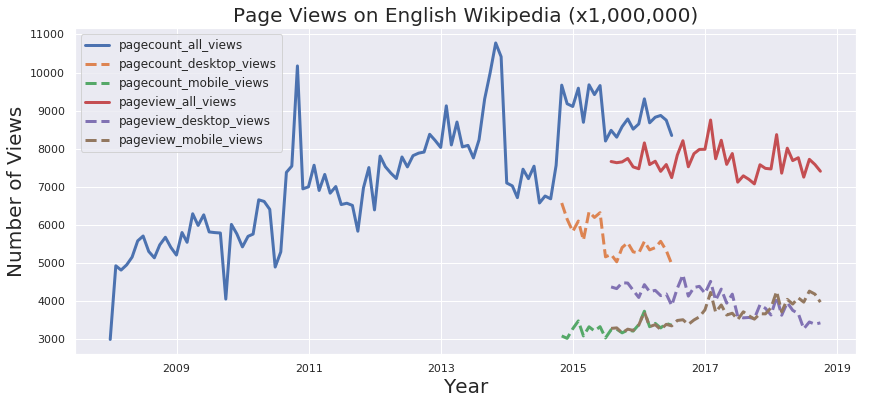

In [107]:
# plot range and parameters
start_count = 82
end_count = 103
start_view = 91
lw = 3.0
views_factor = 1e6

# plot visualization
fig, axs = plt.subplots(1, 1, figsize=(14,6))

plt.plot(year_month[:end_count], views['pagecount_all_views'][:end_count]/views_factor,
         ls='-', linewidth=lw)
plt.plot(year_month[start_count:end_count], views['pagecount_desktop_views'][start_count:end_count]/views_factor,
         ls='--', linewidth=lw)
plt.plot(year_month[start_count:end_count], views['pagecount_mobile_views'][start_count:end_count]/views_factor, 
         ls='--', linewidth=lw)
plt.plot(year_month[start_view:], views['pageview_all_views'][start_view:]/views_factor, 
         ls='-', linewidth=lw)
plt.plot(year_month[start_view:], views['pageview_desktop_views'][start_view:]/views_factor, 
         ls='--', linewidth=lw)
plt.plot(year_month[start_view:], views['pageview_mobile_views'][start_view:]/views_factor, 
         ls='--', linewidth=lw)

plt.title('Page Views on English Wikipedia (x1,000,000)', fontsize=20)
plt.legend(prop={'size': 12})
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Views', fontsize=20)

plt.show()

In [110]:
# save figure 
fig.savefig('a1-visualization.png')